In [1]:
# %load_ext autoreload
# %autoreload 2
import time
import numpy as np
import pinocchio as pin
from matplotlib import pyplot as plt

from robot_properties_b1.config import B1Config
from robot_properties_b1.b1wrapper import B1Robot
from mpc.b1_cyclic_gen import B1MpcGaitGen
from motions.cyclic.b1_trot import trot
from motions.cyclic.b1_jump import jump
from motions.weight_abstract import BiconvexMotionParams

pybullet build time: May 20 2022 19:44:17


In [2]:
## robot config and init
pin_robot = B1Config.buildRobotWrapper()
urdf_path = B1Config.urdf_path

n_eff = 4
q0 = np.array(B1Config.initial_configuration)
q0[0:2] = 0.0
q0[2] = 0.4

v0 = pin.utils.zero(pin_robot.model.nv)
x0 = np.concatenate([q0, pin.utils.zero(pin_robot.model.nv)])
f_arr = ["LF_FOOT", "LH_FOOT", "RF_FOOT", "RH_FOOT"]

In [4]:
viz = pin.visualize.MeshcatVisualizer(pin_robot.model, pin_robot.collision_model, pin_robot.visual_model)
viz.initViewer(open=False)
viz.loadViewerModel()

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7014/static/


In [3]:
from motions.weight_abstract import BiconvexMotionParams
jump = BiconvexMotionParams("anymal", "Jump")

# Cnt
# jump.gait_period = 0.5
# jump.stance_percent = [0.4, 0.4, 0.4, 0.4]
# jump.gait_dt = 0.05
# jump.phase_offset = [0.3, 0.3, 0.3, 0.3]

jump.gait_period = 0.9
jump.stance_percent = [0.6, 0.6, 0.6, 0.6]
jump.gait_dt = 0.05
jump.phase_offset = [0.0, 0.5, 0.5, 0.0]

# IK
jump.state_wt = np.array([0., 0, 10] + [1000, 1000, 1000] + [1e3] * (pin_robot.model.nv - 6) \
                        + [0.00] * 3 + [100, 100, 100] + [5e0] *(pin_robot.model.nv - 6))

jump.ctrl_wt = [0, 0, 1000] + [5e2, 5e2, 5e2] + [10.0] *(pin_robot.model.nv - 6)

jump.swing_wt = [1e5, 1e4]
jump.cent_wt = [3*[0*5e+1], 6*[5e+1]]
jump.step_ht = 0.05
jump.nom_ht = 0.34
jump.reg_wt = [5e-2, 1e-5]

# Dyn 
jump.W_X =        np.array([1e-5, 1e-5, 1e+5, 1e+1, 1e+1, 2e+2, 1e+4, 1e+4, 1e4])
jump.W_X_ter = 10*np.array([1e+5, 1e-5, 1e+5, 1e+1, 1e+1, 2e+2, 1e+5, 1e+5, 1e+5])
jump.W_F = np.array(4*[1e+2, 1e+2, 1e+2])
jump.rho = 5e+4
jump.ori_correction = [0.3, 0.5, 0.3]
jump.gait_horizon = 10.0
jump.kp = 150.0
jump.kd = 10.0

In [4]:
## Motion
trot.gait_horizon = 1.0
gait_params = trot

## robot config and init
gait_time = gait_params.gait_period
dt = 5e-2

n_eff = 4
# q0[7:13] = 2 * [0.0, -0.8, 1.6]

v0 = pin.utils.zero(pin_robot.model.nv)
x0 = np.concatenate([q0, pin.utils.zero(pin_robot.model.nv)])

w_des = 1.0
v_des = np.array([0.5, 0.0, 0])

update_time = 0.02 # sec (time of lag)

n = 1

sim_t = 0.0
step_t = 0
sim_dt = .001
plan_freq = 5.0

gg = B1MpcGaitGen(pin_robot, urdf_path, x0, plan_freq, q0, None)
gg.update_gait_params(gait_params, sim_t)

Initialized Kino-Dyn planner


In [9]:
viz.viewer.jupyter_cell()

In [5]:
q = q0
v = v0
step_t = 0
n = 0

xs_plan, us_plan, f_plan = gg.optimize(q, v, np.round(sim_t,3), v_des, w_des)

# for ind in range(int(xs_plan.shape[0])):
#     viz.display(xs_plan[ind][:pin_robot.model.nq])

Maximum iterations reached 
Cost Time : 0.032678842544555664
Solve Time :  1.0309906005859375
Final norm: 27.0598


In [6]:
v_des = np.array([0.5, 0.0, 0])
w_des = 5.0
cnt_plan = gg.create_cnt_plan(q, v, np.round(sim_t, 3), v_des, w_des)

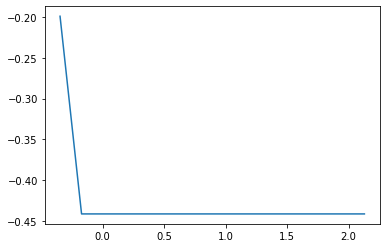

In [16]:
idx = 3

# plt.plot(cnt_plan[:, idx, 0] * cnt_plan[:, idx, 3])
plt.plot(cnt_plan[:, idx, 1], cnt_plan[:, idx, 2])

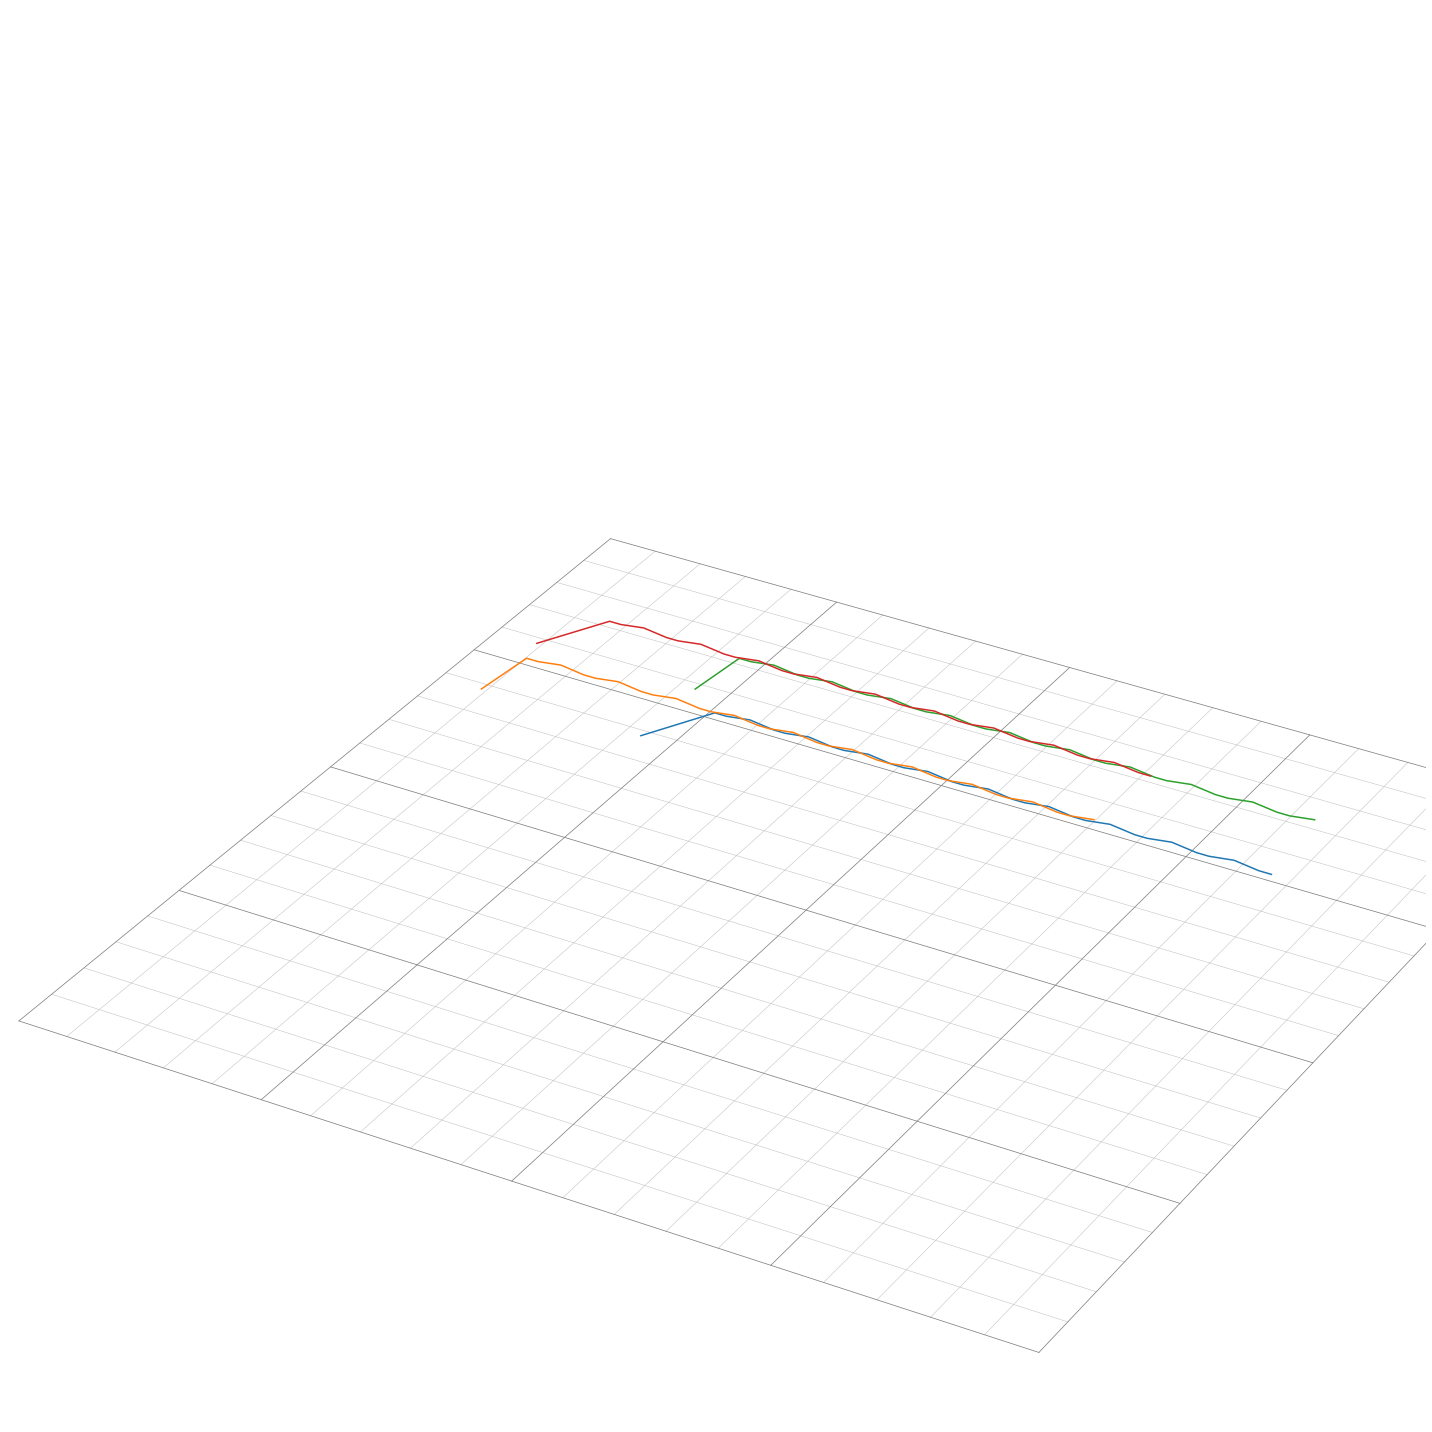

In [7]:
fig = plt.figure(figsize=(20, 20))
ax = plt.subplot(1, 1, 1, projection="3d")
ax.set_axis_off()
ax.set_xlim(0, 3)
ax.set_ylim(3, 0)
ax.set_zlim(0, 3)

for d in np.arange(0, 21):
    color, linewidth, zorder = "0.75", 0.5, -100
    if d in [0, 5, 10, 15, 20]:
        color, linewidth, zorder = "0.5", 0.75, -50
    ax.plot([-0.5 + 0.2 * d, -0.5 + 0.2 * d], [-1, -1 + 0.2 * 20], [0, 0], linewidth=linewidth, color=color, zorder=zorder)
    ax.plot([-0.5 + 0, -0.5 + 0.2 * 20], [-1 + 0.2 * d, -1 + 0.2 * d], [0, 0], linewidth=linewidth, color=color, zorder=zorder)

# size, color = "small", "0.75"
# for d in np.arange(1, 11):
#     ax.text(d, 10.75, 0, "%d" % d, color=color, size=size, ha="center", va="center")
#     ax.text(10.5, d, 0, "%d" % d, color=color, size=size, ha="center", va="center")

ax.plot(cnt_plan[:, 0, 1], cnt_plan[:, 0, 2], cnt_plan[:, 0, 0] * cnt_plan[:, 0, 3])
ax.plot(cnt_plan[:, 1, 1], cnt_plan[:, 1, 2], cnt_plan[:, 1, 0] * cnt_plan[:, 1, 3])
ax.plot(cnt_plan[:, 2, 1], cnt_plan[:, 2, 2], cnt_plan[:, 2, 0] * cnt_plan[:, 2, 3])
ax.plot(cnt_plan[:, 3, 1], cnt_plan[:, 3, 2], cnt_plan[:, 3, 0] * cnt_plan[:, 3, 3])

plt.tight_layout()
plt.savefig("footplan.png")
plt.show()